In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import os                                       # For listing classes of my dataset directory
import torch                                           
import torchvision
import torch.nn as nn
import torch.nn.functional as F                 # For using some functions like cross_entropy() and etc
import matplotlib.pyplot as plt                 # For plotting the accuracy and loss of the model
import jovian
from torchvision import transforms as ts        # For transforming image dataset like scaling, converting to tensors, etc.
from torchvision.datasets import ImageFolder    # For creating an image folder from a dataset directory using transforms
from torchvision.transforms import ToTensor     # For converting image dataset to tensors
from torch.utils.data.dataloader import DataLoader   # For accessing dataset in iterative batches and with shufflung, etc.
from torchvision.utils import make_grid         # For making a grid of images from the dataset

<IPython.core.display.Javascript object>

In [3]:
dataset_url = 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'
Dataset_dir = '../input/chest-xray-pneumonia/chest_xray'
classes = os.listdir(Dataset_dir+'/train')
print(classes)

['NORMAL', 'PNEUMONIA']


Dataset directory was created here from the dataset url and the classes of dataset are printed with the help of *listdir*.

In [4]:
# Data transforms
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_ts = ts.Compose([ts.Resize((32,32)),
                       ts.RandomCrop(32, padding=1, padding_mode='reflect'),
                       ts.RandomHorizontalFlip(),
                       ts.ToTensor(), 
                       ts.Normalize(*stats,inplace=True)])
valid_ts = ts.Compose([ts.Resize((32,32)), ts.ToTensor(), ts.Normalize(*stats)])

In [5]:
dataset = ImageFolder(Dataset_dir+'/train',train_ts)
val_ds = ImageFolder(Dataset_dir+'/val',valid_ts)
test_ds = ImageFolder(Dataset_dir+'/test',valid_ts)
len(dataset)

5216

In [6]:
image, label = dataset[110]
print(image.shape, label)

torch.Size([3, 32, 32]) 0


Label:  NORMAL (0)


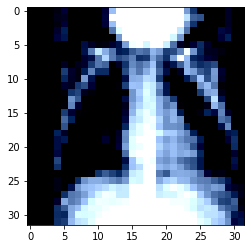

In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[1000])

Label:  PNEUMONIA (1)


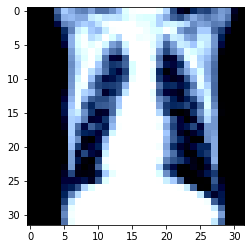

In [8]:
show_example(*dataset[4000])

Training and Validation sets

In [9]:
batch_size = 400
train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

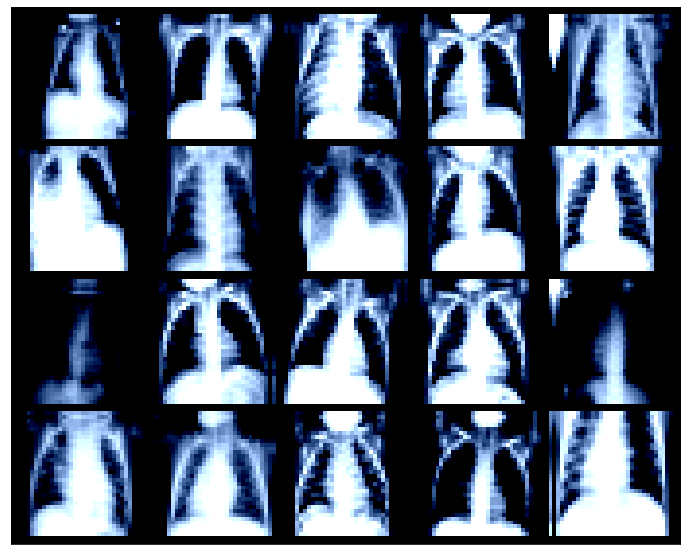

In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:20], nrow=5).permute(1, 2, 0))
        break
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

Resnet

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [25]:
model = to_device(ResNet9(3, 2), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), lr, weight_decay=weight_decay)
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6903533935546875, 'val_acc': 0.5}]

In [28]:
epochs = 10
lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [29]:
history += fit(epochs, lr, model, train_dl, val_dl, 
               grad_clip=grad_clip, 
               weight_decay=weight_decay, 
               opt_func=opt_func)

Epoch [0], train_loss: 1.7935, val_loss: 13.2098, val_acc: 0.5625
Epoch [1], train_loss: 0.5097, val_loss: 1.2299, val_acc: 0.5000
Epoch [2], train_loss: 0.3999, val_loss: 1.5127, val_acc: 0.5000
Epoch [3], train_loss: 0.4295, val_loss: 0.6743, val_acc: 0.7500
Epoch [4], train_loss: 0.3432, val_loss: 1.0143, val_acc: 0.6250
Epoch [5], train_loss: 0.2536, val_loss: 1.5101, val_acc: 0.6250
Epoch [6], train_loss: 0.2784, val_loss: 0.9111, val_acc: 0.4375
Epoch [7], train_loss: 0.2465, val_loss: 0.8319, val_acc: 0.4375
Epoch [8], train_loss: 0.2538, val_loss: 2.2726, val_acc: 0.4375
Epoch [9], train_loss: 0.4464, val_loss: 0.8136, val_acc: 0.5625


In [30]:
epochs = 10
lr = 0.001

In [31]:
history += fit(epochs, lr, model, train_dl, val_dl, 
               grad_clip=grad_clip, 
               weight_decay=weight_decay, 
               opt_func=opt_func)

Epoch [0], train_loss: 0.2237, val_loss: 1.0397, val_acc: 0.5000
Epoch [1], train_loss: 0.1666, val_loss: 1.5123, val_acc: 0.5625
Epoch [2], train_loss: 0.1505, val_loss: 0.6820, val_acc: 0.5625
Epoch [3], train_loss: 0.1229, val_loss: 1.1697, val_acc: 0.5625


KeyboardInterrupt: 

In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

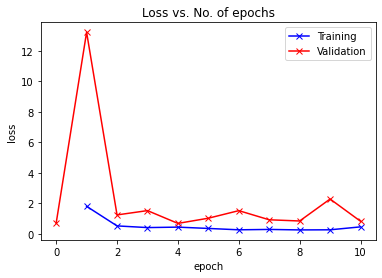

In [33]:
plot_losses(history)

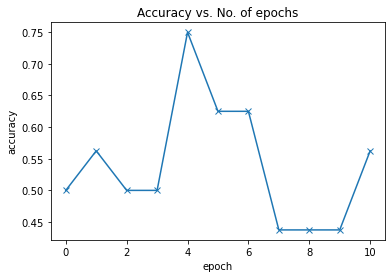

In [34]:
plot_accuracies(history)

Testing Images

In [35]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: NORMAL , Predicted: PNEUMONIA


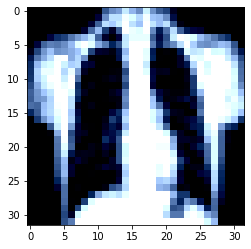

In [36]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: NORMAL , Predicted: PNEUMONIA


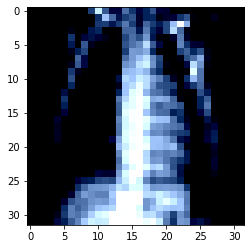

In [37]:
img, label = test_ds[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: PNEUMONIA , Predicted: PNEUMONIA


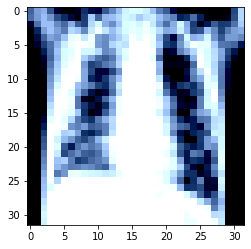

In [38]:
img, label = test_ds[600]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [39]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.7113291621208191, 'val_acc': 0.7820512652397156}

In [40]:
project_name = 'pneumonia-resnet-project'
jovian.commit(project = project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sswaroop46/pneumonia-resnet-project


<IPython.core.display.Javascript object>